In [ ]:
import mlflow
import mlflow.sklearn
import logging
import sys
import time
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import os
import sys
import string

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [4]:
df = pd.read_csv('IMDB.csv')

In [5]:
def lemmatization(text):
    """Lemmatize the text."""
    lemmatizer = WordNetLemmatizer()
    text = text.split()
    text = [lemmatizer.lemmatize(word) for word in text]
    return " ".join(text)

def remove_stop_words(text):
    """Remove stop words from the text."""
    stop_words = set(stopwords.words("english"))
    text = [word for word in str(text).split() if word not in stop_words]
    return " ".join(text)

def removing_numbers(text):
    """Remove numbers from the text."""
    text = ''.join([char for char in text if not char.isdigit()])
    return text

def lower_case(text):
    """Convert text to lower case."""
    text = text.split()
    text = [word.lower() for word in text]
    return " ".join(text)

def removing_punctuations(text):
    """Remove punctuations from the text."""
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = text.replace('؛', "")
    text = re.sub('\s+', ' ', text).strip()
    return text

def removing_urls(text):
    """Remove URLs from the text."""
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def normalize_text(df):
    """Normalize the text data."""
    try:
        df['review'] = df['review'].apply(lower_case)
        df['review'] = df['review'].apply(remove_stop_words)
        df['review'] = df['review'].apply(removing_numbers)
        df['review'] = df['review'].apply(removing_punctuations)
        df['review'] = df['review'].apply(removing_urls)
        df['review'] = df['review'].apply(lemmatization)
        return df
    except Exception as e:
        print(f'Error during text normalization: {e}')
        raise


In [6]:
nltk.download('wordnet')
df = normalize_text(df)
df.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,review,sentiment
0,film version sandra bernhard s one woman off b...,negative
1,switched from cable whim treated quite surpris...,positive
2,plot film contains hole could drive massive tr...,negative
3,amusing humor fall flat decent acting quite at...,negative
4,say movie terrible good two day earlier watche...,negative


In [7]:
df['sentiment'] = df['sentiment'].map({'positive':1, 'negative':0})
df.head()

,review,sentiment
0,film version sandra bernhard s one woman off b...,0
1,switched from cable whim treated quite surpris...,1
2,plot film contains hole could drive massive tr...,0
3,amusing humor fall flat decent acting quite at...,0
4,say movie terrible good two day earlier watche...,0


In [8]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [9]:
X = df['review']
y = df['sentiment']

In [10]:
import dagshub
mlflow.set_tracking_uri("https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow")
dagshub.init(repo_owner='Jugal-lachhwani', repo_name='Data-Capstone-Project', mlflow=True)

Accessing as Jugal-lachhwani

Initialized MLflow to track repo "Jugal-lachhwani/Data-Capstone-Project"

Repository Jugal-lachhwani/Data-Capstone-Project initialized!

In [11]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

2025/10/22 16:27:43 INFO mlflow.tracking.fluent: Experiment with name 'IMDB_1st' does not exist. Creating a new experiment.


2025-10-22 16:27:44,988 - INFO - Vectorizer: CountVectorizer
2025-10-22 16:27:45,324 - INFO - Training model: LogisticRegression


2025/10/22 16:28:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run CountVectorizer_LogisticRegression at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3/runs/f5626a7ce80d4fa7ad205d94d7c8aae9.
2025/10/22 16:28:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3.


KeyboardInterrupt: 

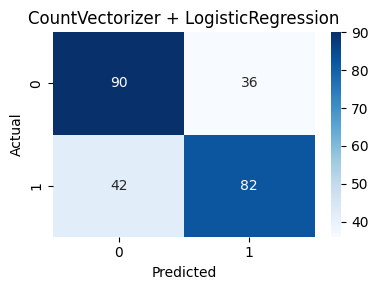

In [12]:
mlflow.set_experiment('IMDB_1st')

# --- Logging setup for notebook ---
for h in logging.root.handlers[:]:
    logging.root.removeHandler(h)
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[logging.StreamHandler(sys.stdout)],
    force=True
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# --- Define preprocessing methods ---
vectorizers = {
    "CountVectorizer": CountVectorizer(max_features=100),
    "TFIDFVectorizer": TfidfVectorizer(max_features=100)
}

# --- Define algorithms and hyperparameters ---

models = {
    "LogisticRegression": {
        "estimator": LogisticRegression(max_iter=1000, random_state=42),
        "param_grid": {
            "C": [0.01, 0.1, 1.0, 10.0],
            "solver": ["lbfgs", "liblinear"]
        }
    },
    "RidgeClassifier": {
        "estimator": RidgeClassifier(random_state=42),
        "param_grid": {
            "alpha": [0.1, 1.0, 10.0]
        }
    },
    "DecisionTree": {
        "estimator": DecisionTreeClassifier(random_state=42),
        "param_grid": {
            "max_depth": [None, 5, 10, 20],
            "min_samples_split": [2, 5, 10]
        }
    },
    "RandomForest": {
        "estimator": RandomForestClassifier(random_state=42),
        "param_grid": {
            "n_estimators": [50, 100, 150, 200],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5, 10]
        }
    },
    "GradientBoosting": {
        "estimator": GradientBoostingClassifier(random_state=42),
        "param_grid": {
            "n_estimators": [100, 200],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [3, 5, 7]
        }
    },
    "AdaBoost": {
        "estimator": AdaBoostClassifier(random_state=42),
        "param_grid": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 1.0]
        }
    },
    "SVM": {
        "estimator": SVC(probability=True, random_state=42),
        "param_grid": {
            "C": [0.1, 1, 10],
            "kernel": ["linear", "rbf"]
        }
    },
    "KNN": {
        "estimator": KNeighborsClassifier(),
        "param_grid": {
            "n_neighbors": [3, 5, 7, 9],
            "weights": ["uniform", "distance"]
        }
    },
    "XGBoost": {
        "estimator": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        "param_grid": {
            "n_estimators": [100, 200],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [3, 5, 7]
        }
    },
    "LightGBM": {
        "estimator": LGBMClassifier(random_state=42),
        "param_grid": {
            "n_estimators": [100, 200],
            "learning_rate": [0.01, 0.1, 0.2],
            "num_leaves": [31, 50, 100]
        }
    }
}




# --- Loop through all combinations ---
for vec_name, vec in vectorizers.items():
    logging.info(f"Vectorizer: {vec_name}")

    X_train_vec = vec.fit_transform(X_train)
    X_test_vec = vec.transform(X_test)

    for model_name, model_info in models.items():
        logging.info(f"Training model: {model_name}")

        with mlflow.start_run(run_name=f"{vec_name}_{model_name}"):

            start_time = time.time()

            # Fit GridSearchCV
            grid = GridSearchCV(
                estimator=model_info["estimator"],
                param_grid=model_info["param_grid"],
                cv=3,
                n_jobs=-1,
                verbose=0
            )

            grid.fit(X_train_vec, y_train)
            best_model = grid.best_estimator_

            y_pred = best_model.predict(X_test_vec)

            # --- Calculate metrics ---
            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred)
            rec = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)

            # --- Log parameters ---
            mlflow.log_param("vectorizer", vec_name)
            mlflow.log_param("model", model_name)
            mlflow.log_params(grid.best_params_)

            # --- Log metrics ---
            mlflow.log_metrics({
                "accuracy": acc,
                "precision": prec,
                "recall": rec,
                "f1": f1
            })

            # --- Log classification report ---
            report = classification_report(y_test, y_pred, output_dict=True)
            mlflow.log_dict(report, "classification_report.json")

            # --- Log confusion matrix ---
            conf = confusion_matrix(y_test, y_pred)
            conf_dict = {"confusion_matrix": conf.tolist()}
            mlflow.log_dict(conf_dict, "confusion_matrix.json")

            # --- Optional: confusion matrix plot ---
            plt.figure(figsize=(4,3))
            sns.heatmap(conf, annot=True, fmt="d", cmap="Blues")
            plt.xlabel("Predicted")
            plt.ylabel("Actual")
            plt.title(f"{vec_name} + {model_name}")
            plt.tight_layout()
            plt.savefig("confusion_matrix.png")
            mlflow.log_artifact("confusion_matrix.png")

            # --- Log model ---
            input_example = (
                X_test_vec[:5].toarray() if scipy.sparse.issparse(X_test_vec)
                else X_test_vec[:5]
            )
            mlflow.sklearn.log_model(best_model, "model", input_example=input_example)

            end_time = time.time()
            mlflow.log_metric("training_time_sec", end_time - start_time)

            logging.info(f"{vec_name} + {model_name} -> acc={acc:.3f}, f1={f1:.3f}")

2025-10-22 17:03:52,955 - INFO - Vectorizer: TFIDFVectorizer
2025-10-22 17:03:53,296 - INFO - Training model: LogisticRegression


2025/10/22 17:04:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run TFIDFVectorizer_LogisticRegression_grid_0 at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3/runs/49fe527019854101bc56b3ff98affb52.
2025/10/22 17:04:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3.
2025/10/22 17:04:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run TFIDFVectorizer_LogisticRegression_grid_1 at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3/runs/97676347d631440098f30178285ce7f1.
2025/10/22 17:04:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3.


2025-10-22 17:04:18,429 - INFO - Best params found: {'C': 0.1, 'solver': 'lbfgs'}


2025-10-22 17:04:42,837 - INFO - TFIDFVectorizer + LogisticRegression -> acc=0.688, f1=0.655


2025/10/22 17:04:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run TFIDFVectorizer_LogisticRegression_grid_2 at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3/runs/24fd5b43c8854cdfa66fa3e25b3328d8.
2025/10/22 17:04:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3.
2025/10/22 17:04:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run TFIDFVectorizer_LogisticRegression_grid_3 at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3/runs/0a7233ff2c5d4692814ade4138a01137.
2025/10/22 17:04:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3.
2025/10/22 17:04:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run TFIDFVectorizer_LogisticRegression_grid_4 at: https://dagshub.com/Jugal-lachhwani/Data-Capst

2025-10-22 17:05:24,416 - INFO - Training model: RidgeClassifier


2025/10/22 17:05:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run TFIDFVectorizer_RidgeClassifier_grid_0 at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3/runs/6bd82467c4d94e9ba353f5f83ff0c6cd.
2025/10/22 17:05:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3.


2025-10-22 17:05:38,413 - INFO - Best params found: {'alpha': 1.0}


2025-10-22 17:06:02,709 - INFO - TFIDFVectorizer + RidgeClassifier -> acc=0.688, f1=0.688



2025/10/22 17:06:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run TFIDFVectorizer_RidgeClassifier_grid_1 at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3/runs/5acd4ba1c2a54acf9504f56aecb0ceb2.
2025/10/22 17:06:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3.
2025/10/22 17:06:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run TFIDFVectorizer_RidgeClassifier_grid_2 at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3/runs/2f5046df3f5e4c62a9d68b443fe2e985.
2025/10/22 17:06:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3.


2025-10-22 17:06:12,471 - INFO - Training model: DecisionTree


2025/10/22 17:06:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run TFIDFVectorizer_DecisionTree_grid_0 at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3/runs/44fe2827a2c24ff6bc38618f220e7d48.
2025/10/22 17:06:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3.
2025/10/22 17:06:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run TFIDFVectorizer_DecisionTree_grid_1 at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3/runs/ba9344ffab8140009a649dd888d9aafe.
2025/10/22 17:06:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3.
2025/10/22 17:06:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run TFIDFVectorizer_DecisionTree_grid_2 at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow

2025-10-22 17:06:50,413 - INFO - Best params found: {'max_depth': 5, 'min_samples_split': 5}


2025-10-22 17:07:14,702 - INFO - TFIDFVectorizer + DecisionTree -> acc=0.560, f1=0.534



2025/10/22 17:07:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run TFIDFVectorizer_DecisionTree_grid_4 at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3/runs/a3d4f021ad3b4ccdb6dd4cba402a0f35.
2025/10/22 17:07:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3.
2025/10/22 17:07:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run TFIDFVectorizer_DecisionTree_grid_5 at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3/runs/5efb019174cc4d6fa405f7c9c2c33c8d.
2025/10/22 17:07:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3.
2025/10/22 17:07:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run TFIDFVectorizer_DecisionTree_grid_6 at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflo

2025-10-22 17:08:13,681 - INFO - Training model: RandomForest


2025/10/22 17:08:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run TFIDFVectorizer_RandomForest_grid_0 at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3/runs/3d14b9df80d948c2b1a71ae1f391a6dc.
2025/10/22 17:08:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3.
2025/10/22 17:08:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run TFIDFVectorizer_RandomForest_grid_1 at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3/runs/810465c2791f4746ab5441ec84f88b96.
2025/10/22 17:08:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3.
2025/10/22 17:08:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run TFIDFVectorizer_RandomForest_grid_2 at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow

2025-10-22 17:10:55,755 - INFO - Best params found: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}


2025-10-22 17:12:11,099 - INFO - TFIDFVectorizer + RandomForest -> acc=0.676, f1=0.669


2025/10/22 17:12:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run TFIDFVectorizer_RandomForest_grid_19 at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3/runs/5efe45b0745f4171bcf3b22c3b48e12b.
2025/10/22 17:12:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3.
2025/10/22 17:12:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run TFIDFVectorizer_RandomForest_grid_20 at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3/runs/fd0ed472653c4d79956bdb8e1a06a991.
2025/10/22 17:12:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3.
2025/10/22 17:12:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run TFIDFVectorizer_RandomForest_grid_21 at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlf

2025-10-22 17:14:12,511 - INFO - Training model: GradientBoosting


2025/10/22 17:15:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run TFIDFVectorizer_GradientBoosting_grid_0 at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3/runs/11d7826bc4e04958b6d22dc996d86b60.
2025/10/22 17:15:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3.
2025/10/22 17:15:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run TFIDFVectorizer_GradientBoosting_grid_1 at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3/runs/5fcc2d975717493d93d861be5c016391.
2025/10/22 17:15:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3.
2025/10/22 17:15:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run TFIDFVectorizer_GradientBoosting_grid_2 at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Pr

2025-10-22 17:16:50,176 - INFO - Best params found: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}


2025-10-22 17:17:22,168 - INFO - TFIDFVectorizer + GradientBoosting -> acc=0.640, f1=0.634


2025/10/22 17:17:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run TFIDFVectorizer_GradientBoosting_grid_11 at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3/runs/5f67ab89e9464287936ec10ea60373fd.
2025/10/22 17:17:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3.
2025/10/22 17:17:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run TFIDFVectorizer_GradientBoosting_grid_12 at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3/runs/54d3bbe79d454c3e85bd91a74940541f.
2025/10/22 17:17:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3.
2025/10/22 17:17:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run TFIDFVectorizer_GradientBoosting_grid_13 at: https://dagshub.com/Jugal-lachhwani/Data-Capstone

2025-10-22 17:18:07,626 - INFO - Training model: AdaBoost


2025/10/22 17:18:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run TFIDFVectorizer_AdaBoost_grid_0 at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3/runs/803c870e85f04b79b64e9fd39f97a8f0.
2025/10/22 17:18:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3.
2025/10/22 17:18:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run TFIDFVectorizer_AdaBoost_grid_1 at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3/runs/90355c28741f47719f0f9fb8ba1a5a87.
2025/10/22 17:18:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3.
2025/10/22 17:18:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run TFIDFVectorizer_AdaBoost_grid_2 at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experimen

2025-10-22 17:18:58,234 - INFO - Best params found: {'learning_rate': 0.1, 'n_estimators': 200}


2025-10-22 17:19:32,474 - INFO - TFIDFVectorizer + AdaBoost -> acc=0.672, f1=0.655


2025/10/22 17:19:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run TFIDFVectorizer_AdaBoost_grid_5 at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3/runs/882087ecade548ec82c73bb2854f2c30.
2025/10/22 17:19:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3.
2025/10/22 17:19:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run TFIDFVectorizer_AdaBoost_grid_6 at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3/runs/e617e3049cc5421685cf51d909ceb196.
2025/10/22 17:19:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3.
2025/10/22 17:19:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run TFIDFVectorizer_AdaBoost_grid_7 at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experimen

2025-10-22 17:19:54,699 - INFO - Training model: SVM


2025/10/22 17:20:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run TFIDFVectorizer_SVM_grid_0 at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3/runs/82a5d921500f4411941cab72671aa5cd.
2025/10/22 17:20:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3.
2025/10/22 17:20:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run TFIDFVectorizer_SVM_grid_1 at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3/runs/0d17fad3fdc84d398ae5a6244814fe02.
2025/10/22 17:20:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3.
2025/10/22 17:20:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run TFIDFVectorizer_SVM_grid_2 at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3/runs/954ff

2025-10-22 17:20:32,691 - INFO - Best params found: {'C': 10, 'kernel': 'linear'}


2025-10-22 17:21:02,120 - INFO - TFIDFVectorizer + SVM -> acc=0.692, f1=0.686


2025/10/22 17:21:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run TFIDFVectorizer_SVM_grid_4 at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3/runs/71b4da2b31a34175b5a77f467dcb8db6.
2025/10/22 17:21:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3.
2025/10/22 17:21:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run TFIDFVectorizer_SVM_grid_5 at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3/runs/e492015f746246dd933b1d4dee2e2a23.
2025/10/22 17:21:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3.


2025-10-22 17:21:09,069 - INFO - Training model: KNN


2025/10/22 17:21:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run TFIDFVectorizer_KNN_grid_0 at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3/runs/a2b953d9125e452298abc72dfe285cc3.
2025/10/22 17:21:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3.
2025/10/22 17:21:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run TFIDFVectorizer_KNN_grid_1 at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3/runs/5b7209ac4e3f4da792588bb3d6d7b7aa.
2025/10/22 17:21:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3.
2025/10/22 17:21:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run TFIDFVectorizer_KNN_grid_2 at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3/runs/f8126

2025-10-22 17:22:03,069 - INFO - Best params found: {'n_neighbors': 9, 'weights': 'uniform'}
2025-10-22 17:22:52,143 - WARNING - Retrying (Retry(total=4, connect=5, read=4, redirect=5, status=5)) after connection broken by 'RemoteDisconnected('Remote end closed connection without response')': /Jugal-lachhwani/Data-Capstone-Project.mlflow/api/2.0/mlflow-artifacts/artifacts/ac15dc126a5b4643985e05484a02c235/fa0511ff88c74a03b450fd8dd262b39e/artifacts/best_model/conda.yaml
2025-10-22 17:22:57,239 - WARNING - Retrying (Retry(total=3, connect=5, read=3, redirect=5, status=5)) after connection broken by 'ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None)': /Jugal-lachhwani/Data-Capstone-Project.mlflow/api/2.0/mlflow-artifacts/artifacts/ac15dc126a5b4643985e05484a02c235/fa0511ff88c74a03b450fd8dd262b39e/artifacts/best_model/conda.yaml


2025-10-22 17:23:09,965 - INFO - TFIDFVectorizer + KNN -> acc=0.620, f1=0.589


2025/10/22 17:23:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run TFIDFVectorizer_KNN_grid_6 at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3/runs/fa0511ff88c74a03b450fd8dd262b39e.
2025/10/22 17:23:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3.
2025/10/22 17:23:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run TFIDFVectorizer_KNN_grid_7 at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3/runs/a7db3f58e932463f91954b240a8e88d8.
2025/10/22 17:23:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3.


2025-10-22 17:23:15,466 - INFO - Training model: XGBoost


c:\Users\DELL\miniconda3\envs\simple_env\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:24:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
2025/10/22 17:24:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run TFIDFVectorizer_XGBoost_grid_0 at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3/runs/2f629eab1277449fbea059988fa19ef4.
2025/10/22 17:24:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3.
2025/10/22 17:24:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run TFIDFVectorizer_XGBoost_grid_1 at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3/runs/172129636b4f48fe896d2dc81bd1fd22.
2025/10/22 17:24:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: h

2025-10-22 17:24:57,757 - INFO - Best params found: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}


2025-10-22 17:25:46,117 - INFO - TFIDFVectorizer + XGBoost -> acc=0.668, f1=0.667


2025/10/22 17:25:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run TFIDFVectorizer_XGBoost_grid_3 at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3/runs/2cae145e979547e3b185c0880019ef92.
2025/10/22 17:25:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3.
2025/10/22 17:25:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run TFIDFVectorizer_XGBoost_grid_4 at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3/runs/54f66d681667438b897851d06d2cd977.
2025/10/22 17:25:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3.
2025/10/22 17:25:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run TFIDFVectorizer_XGBoost_grid_5 at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/

2025-10-22 17:27:35,501 - INFO - Training model: MultinomialNB
2025-10-22 17:27:41,497 - INFO - Best params found: {'alpha': 0.1}


2025-10-22 17:28:26,137 - INFO - TFIDFVectorizer + MultinomialNB -> acc=0.704, f1=0.673


2025/10/22 17:28:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run TFIDFVectorizer_MultinomialNB_grid_0 at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3/runs/2cc358a3691d42a9b2b513dc15f49001.
2025/10/22 17:28:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3.
2025/10/22 17:28:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run TFIDFVectorizer_MultinomialNB_grid_1 at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3/runs/2cbda1bfe1734ec5af728fc2f1af291c.
2025/10/22 17:28:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3.
2025/10/22 17:28:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run TFIDFVectorizer_MultinomialNB_grid_2 at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlf

2025-10-22 17:28:39,618 - INFO - Training model: BernoulliNB


2025/10/22 17:28:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run TFIDFVectorizer_BernoulliNB_grid_0 at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3/runs/3048ac2f3c6c4911a78177a37f4ca0b4.
2025/10/22 17:28:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3.
2025/10/22 17:28:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run TFIDFVectorizer_BernoulliNB_grid_1 at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3/runs/5c35a864d53e4414ac1e98ea757cb680.
2025/10/22 17:28:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3.
2025/10/22 17:29:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run TFIDFVectorizer_BernoulliNB_grid_2 at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/

2025-10-22 17:29:09,575 - INFO - Best params found: {'alpha': 0.5, 'binarize': 0.0}


2025-10-22 17:29:54,436 - WARNING - Retrying (Retry(total=4, connect=5, read=4, redirect=5, status=5)) after connection broken by 'RemoteDisconnected('Remote end closed connection without response')': /Jugal-lachhwani/Data-Capstone-Project.mlflow/api/2.0/mlflow-artifacts/artifacts/ac15dc126a5b4643985e05484a02c235/598cda19f6f944bf819fa35314dddb06/artifacts/best_model/requirements.txt


2025-10-22 17:29:56,278 - INFO - TFIDFVectorizer + BernoulliNB -> acc=0.664, f1=0.667


2025/10/22 17:29:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run TFIDFVectorizer_BernoulliNB_grid_3 at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3/runs/598cda19f6f944bf819fa35314dddb06.
2025/10/22 17:29:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3.
2025/10/22 17:30:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run TFIDFVectorizer_BernoulliNB_grid_4 at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3/runs/6d005913e42a4cbfadc39e7b1d3ea9c1.
2025/10/22 17:30:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/experiments/3.
2025/10/22 17:30:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run TFIDFVectorizer_BernoulliNB_grid_5 at: https://dagshub.com/Jugal-lachhwani/Data-Capstone-Project.mlflow/#/

2025-10-22 17:30:38,373 - INFO - ✅ All models and parameters logged to MLflow successfully!


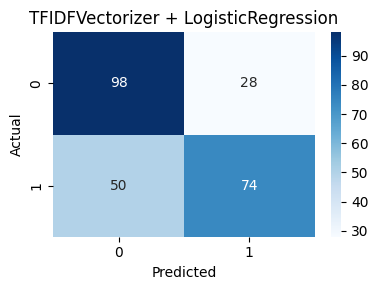

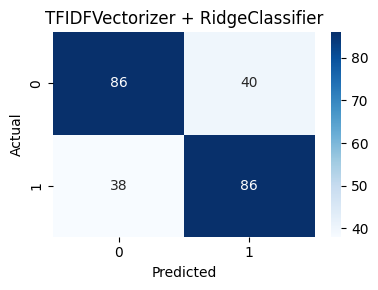

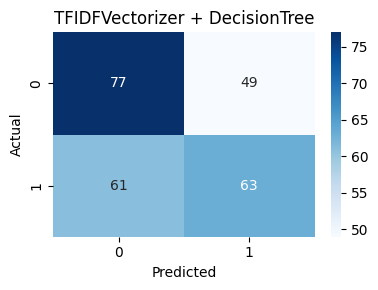

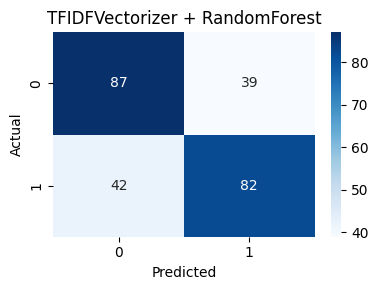

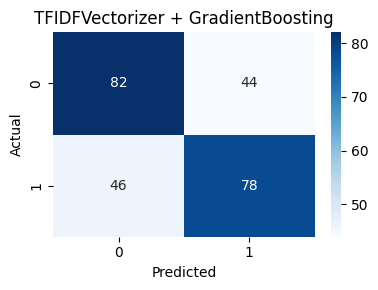

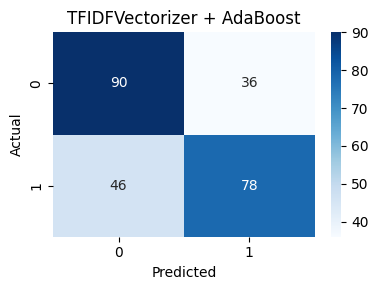

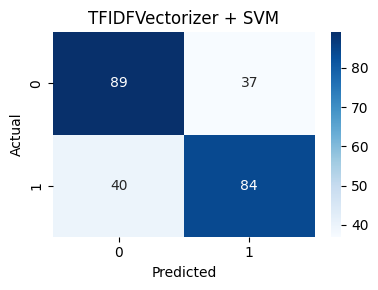

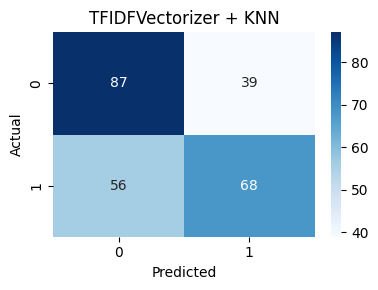

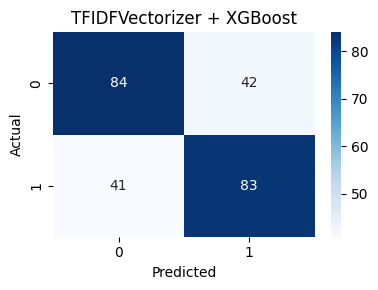

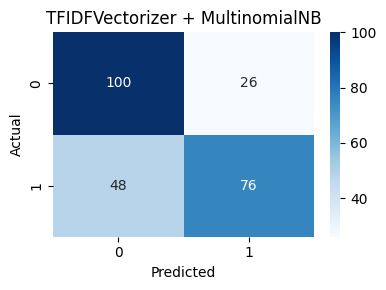

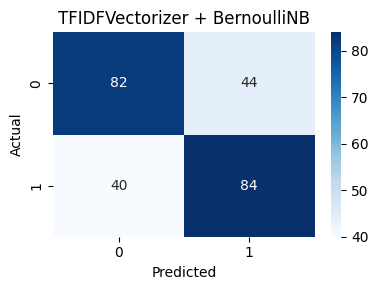

In [14]:
import mlflow
import mlflow.sklearn
import logging
import sys
import time
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

# --- Logging setup ---
for h in logging.root.handlers[:]:
    logging.root.removeHandler(h)
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[logging.StreamHandler(sys.stdout)],
    force=True
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# --- Define preprocessing methods ---
vectorizers = {
    "TFIDFVectorizer": TfidfVectorizer(max_features=100)
}

# --- Define models and hyperparameters ---
models = {
    "LogisticRegression": {
        "estimator": LogisticRegression(max_iter=1000, random_state=42),
        "param_grid": {
            "C": [0.01, 0.1, 1.0, 10.0],
            "solver": ["lbfgs", "liblinear"]
        }
    },
    "RidgeClassifier": {
        "estimator": RidgeClassifier(random_state=42),
        "param_grid": {
            "alpha": [0.1, 1.0, 10.0]
        }
    },
    "DecisionTree": {
        "estimator": DecisionTreeClassifier(random_state=42),
        "param_grid": {
            "max_depth": [None, 5, 10, 20],
            "min_samples_split": [2, 5, 10]
        }
    },
    "RandomForest": {
        "estimator": RandomForestClassifier(random_state=42),
        "param_grid": {
            "n_estimators": [50, 100, 150, 200],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5, 10]
        }
    },
    "GradientBoosting": {
        "estimator": GradientBoostingClassifier(random_state=42),
        "param_grid": {
            "n_estimators": [100, 200],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [3, 5, 7]
        }
    },
    "AdaBoost": {
        "estimator": AdaBoostClassifier(random_state=42),
        "param_grid": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 1.0]
        }
    },
    "SVM": {
        "estimator": SVC(probability=True, random_state=42),
        "param_grid": {
            "C": [0.1, 1, 10],
            "kernel": ["linear", "rbf"]
        }
    },
    "KNN": {
        "estimator": KNeighborsClassifier(),
        "param_grid": {
            "n_neighbors": [3, 5, 7, 9],
            "weights": ["uniform", "distance"]
        }
    },
    "XGBoost": {
        "estimator": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        "param_grid": {
            "n_estimators": [100, 200],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [3, 5, 7]
        }
    },
    "MultinomialNB": {
        "estimator": MultinomialNB(),
        "param_grid": {
            "alpha": [0.1, 0.5, 1.0]
        }
    },
    "BernoulliNB": {
        "estimator": BernoulliNB(),
        "param_grid": {
            "alpha": [0.1, 0.5, 1.0],
            "binarize": [0.0, 0.5, 1.0]
        }
    }
}

# --- Loop through all combinations ---
with mlflow.start_run(run_name='All_experiments') as parent_run:
    
    for vec_name, vec in vectorizers.items():
        logging.info(f"Vectorizer: {vec_name}")

        X_train_vec = vec.fit_transform(X_train)
        X_test_vec = vec.transform(X_test)

        for model_name, model_info in models.items():
            logging.info(f"Training model: {model_name}")

            # --- Train GridSearchCV ---
            grid = GridSearchCV(
                estimator=model_info["estimator"],
                param_grid=model_info["param_grid"],
                cv=3,
                n_jobs=-1,
                verbose=0,
                return_train_score=True
            )
            grid.fit(X_train_vec, y_train)

            # --- Log each parameter combination ---
            for i, params in enumerate(grid.cv_results_["params"]):
                with mlflow.start_run(run_name=f"{vec_name}_{model_name}_grid_{i}", nested=True) as child_run:
                    # Log params and CV scores
                    mlflow.log_param("vectorizer", vec_name)
                    mlflow.log_param("model", model_name)
                    mlflow.log_params(params)

                    mlflow.log_metric("mean_test_score", grid.cv_results_["mean_test_score"][i])
                    mlflow.log_metric("mean_train_score", grid.cv_results_["mean_train_score"][i])

                    # If this is the best params, log full model, metrics, etc.
                    if params == grid.best_params_:
                        logging.info(f"Best params found: {params}")
                        
                        mlflow.set_tag("best_model", "True")
                        
                        best_model = grid.best_estimator_

                        y_pred = best_model.predict(X_test_vec)

                        acc = accuracy_score(y_test, y_pred)
                        prec = precision_score(y_test, y_pred)
                        rec = recall_score(y_test, y_pred)
                        f1 = f1_score(y_test, y_pred)

                        mlflow.log_metrics({
                            "accuracy": acc,
                            "precision": prec,
                            "recall": rec,
                            "f1": f1
                        })

                        # Log classification report
                        report = classification_report(y_test, y_pred, output_dict=True)
                        mlflow.log_dict(report, "classification_report.json")

                        # Log confusion matrix
                        conf = confusion_matrix(y_test, y_pred)
                        mlflow.log_dict({"confusion_matrix": conf.tolist()}, "confusion_matrix.json")

                        # Log confusion matrix plot
                        plt.figure(figsize=(4,3))
                        sns.heatmap(conf, annot=True, fmt="d", cmap="Blues")
                        plt.xlabel("Predicted")
                        plt.ylabel("Actual")
                        plt.title(f"{vec_name} + {model_name}")
                        plt.tight_layout()
                        plt.savefig("confusion_matrix.png")
                        mlflow.log_artifact("confusion_matrix.png")

                        # Log model
                        input_example = (
                            X_test_vec[:5].toarray() if scipy.sparse.issparse(X_test_vec)
                            else X_test_vec[:5]
                        )
                        mlflow.sklearn.log_model(best_model, "best_model", input_example=input_example)

                        logging.info(f"{vec_name} + {model_name} -> acc={acc:.3f}, f1={f1:.3f}")

logging.info("✅ All models and parameters logged to MLflow successfully!")